# LWIR Filters Artifact Undistort

## Problem Description
When capturing real-world scenes using TAU2, an unexpected and unclear spherical distortion appears when applying an IR filter.
This artifact only appears when applying a filter, as can be seen from the following example:


In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

data_base_dir = Path(
    r"C:\Users\omriber\Documents\Thesis\MultiSpectralCtrl\download")

data_fname = "cnt1_20210830_h15m53s38.npy"
data = np.load(Path(data_base_dir, data_fname))

fig = make_subplots(1, 2)
fig = px.imshow(data[0, 0], color_continuous_scale='gray',
                title="Pan-Chromatic")

fig.show()
fig = px.imshow(data[1, 0], color_continuous_scale='gray', title="Filter1")
fig.show()


While seemingly similar to vignetting, it's clearly not, as in opposed to vignetting, the center is brighter than the edges (in vignetting its vice-versa).

Moreover, many pixels have a higher intensity level when the filter is applied, in contrast to the expected physical phenomenon, by which the grey level is proportional to the radiated power. This can be clerly observed when using the same dynamic range for showing both images:

In [6]:
fig = px.imshow(data[:2, 0, ...], facet_col=0,
                color_continuous_scale='gray')
fig.layout.annotations[0].text="Pan-Chromatic"
fig.layout.annotations[1].text="Filtered"
fig.show()


This might suggest that some pre-processing is still occuring during image acquisition, despite being canceled by Navot's commands.

## Suggested Undistortion Calibration Workflow:
To overcome the observed distortion, I propose the following workflow:
* Per spatial pixel i,j:
    1. Estimate $\alpha_{i,j}$, the per-pixel scale-factor converting from radiance power to grey-level:
        1. Capture an unfiltered image (pan-chromatic) of the black-body in several temperature set-points, to obtain a grey level per-pixel $GL_{i,j}$
        2. Analytically calculate the expected radiance power by integrating over Plank's spectral radiance density $B(\lambda, T)$: 
            $$P(\lambda_{0,1}, T) = \int_{\lambda_0}^{\lambda_1} B(\lambda, T) d\lambda$$
            Where $B(\lambda, T) = \frac{2h/c^2\lambda^3}{exp(h/KT\lambda)-1}$ is Plank's spectral radiance density, and $\lambda_{0,1}$ should be determined by TAU's natural band-width. 
            
            Alternatively, and assuming an infinite bandwidth with optimal transmission response, we can use the Stefan–Boltzmann law to assert that $P = \frac{1}{\pi} \sigma T^4 $
        
        3. Estimate $\alpha_{i,j}$ using $\hat{\alpha}_{i,j} = \frac{GL_{i,j}}{P}$
        4. Repeat for every temperature set-point to obtain a (linear) regression model for $\hat{\alpha}_{i,j}(T) = a_0T + b_0$
    2. Estimate $\beta^{(f)}_{i,j}$, the per-pixel, per-filter distortion correction coefficients. For each filter (f):
        1. Capture a filtered image of the black-body in several temperature set-points, to obtain a grey level per-pixel $GL^{(f)}_{i,j}$
        2. Analytically calculate the expected radiance power by integrating over Plank's spectral radiance density $B(\lambda, T)$: 
            $$P^{(f)}(\lambda_{0,1}, T) = \int_{\lambda_0}^{\lambda_1} B(\lambda, T) f(\lambda) d\lambda$$
            Where now $\lambda_{0,1}$ are determinde by the filter's band-width, and $f(\lambda)$ is the filter's transmitanse response. This time, as a significant portion of the spectrum is cut-off, the Stefan–Boltzmann law can no longer be used to approximate the integral.
        3. Use $\alpha_{i,j}$ obtained from the pan-chromatic images to estimate the expected grey-level using $\hat{GL^{(f)}_{i,j}} = \hat{\alpha}_{i,j} \cdot P^{(f)}$
        4. Estimate $\beta^{(f)}_{i,j}$ using $\hat{\beta}^{(f)}_{i,j} = \frac{\hat{GL^{(f)}_{i,j}}}{GL^{(f)}_{i,j}}$
        5. Repeat for every temperature set-point to obtain a (linear) regression model for $\hat{\beta}^{(f)}_{i,j}(T) = a_1T + b_1$


## Calculating the Power-Radiance P:
use the API as depicted below:

Input temperature: 32.0000
Estimated temperature (by integrating over plank's function): 31.9996


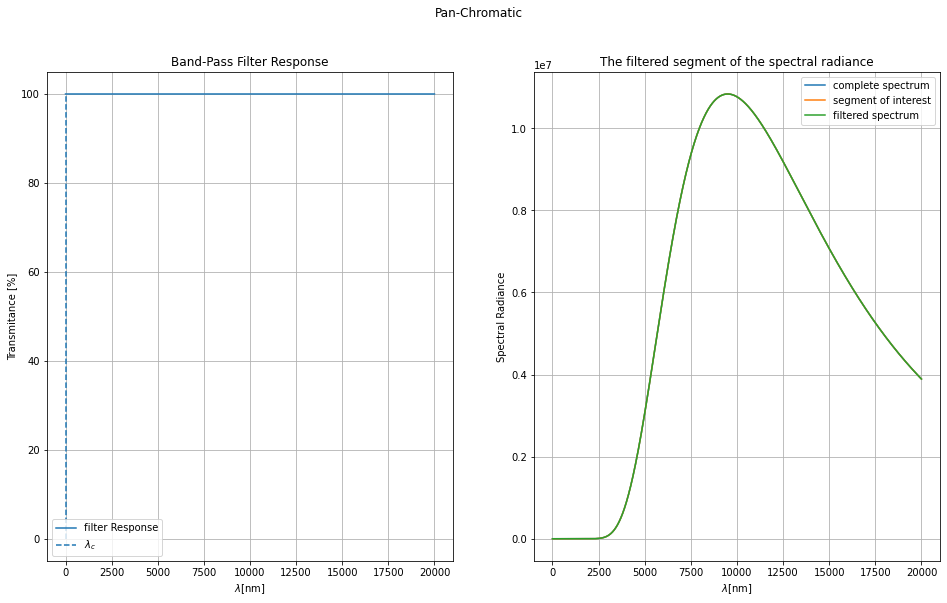

Input temperature: 32.0000
Estimated temperature (by integrating over plank's function): 31.9996


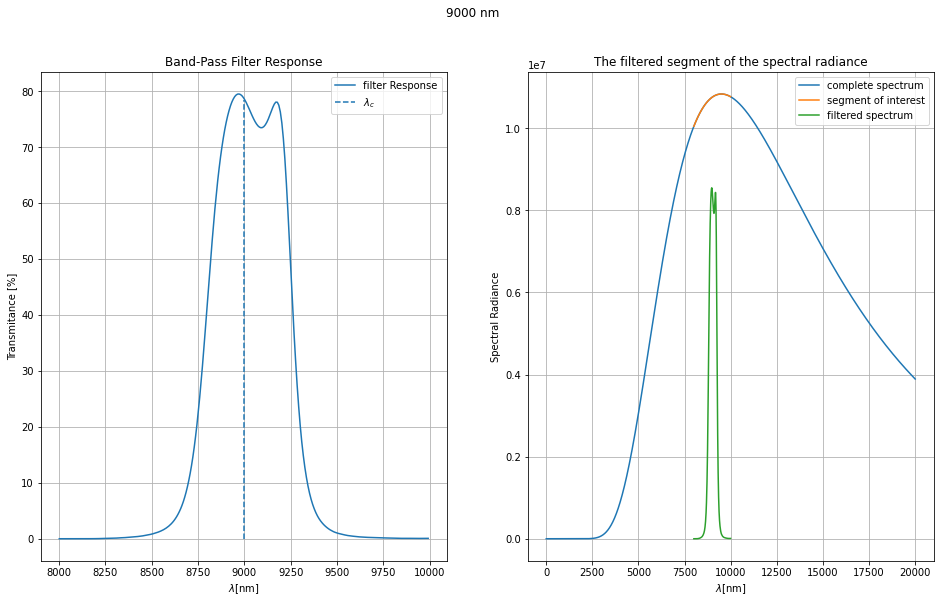

In [2]:
from tools import calcRxPower
import numpy as np
import matplotlib.pyplot as plt
# for pan-chromatic, currently using an ideal, infinitely wide bandwidth filter assumption
rx_power = calcRxPower(temperature=32,  central_wl=0, bw=np.inf, is_ideal_filt=True, debug=True)


# for a specific filter, provide the central frequency:
lambda_c = 9000 #[nm]
rx_power = calcRxPower(temperature=32, central_wl=lambda_c, debug=True)


To avoid generating the figures each time the calculation is invoked, simply set debug=false (or completely remove it as an argument)